## Preamble/setup

In [1]:
import time
import cv2
import random
import json
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

import torch
from torchvision.datasets import CIFAR10
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset, Subset

import utils

In [2]:
# Option for whether to only plot the results from saved scores, or to recalculate from scratch.
# Note this is very slow, but allows reproduction of all results
recalculate_results = True

device_name = utils.get_device()
device = torch.device(device_name)
CNN_params_dict = utils.CNN_params_setup(device)
dropout_conv, dropout_fc = CNN_params_dict['dropout_conv'], CNN_params_dict['dropout_fc']

In [3]:
## Plotting parameters for uniformity
my_fig_size = (7,6) # figure size
ms = 10 # marker size
lw = 4 # line width
title_size = 18
label_size = 14
legend_size = 10

## Original data CNN learning curve

In [4]:
if recalculate_results: # Load the CIFAR-10 data to memory
    full_cifar_dataset = CIFAR10
    # Define data transformations
    transform = transforms.Compose([transforms.ToTensor(),]) # Convert PIL Image to PyTorch Tensor

    train_dataset = full_cifar_dataset(
        root=f'./{"data/cifar-10-orig"}',  # Change the root directory as needed
        train=True,      # Set to True for the training set
        transform=transform,
        download=True)

    test_dataset = full_cifar_dataset(
        root=f'./{"data/cifar-10-orig"}',  # Change the root directory as needed
        train=False,     # Set to False for the test set
        transform=transform,
        download=True)

Files already downloaded and verified
Files already downloaded and verified


### Baseline classification accuracy

In [6]:
# Setup our main n_orig = 1024 sample
N = 1024

seed = 42
random.seed(seed)

random_indices = random.sample(range(len(train_dataset)), N)
train_samp = Subset(train_dataset, random_indices)
# Separate the images and labels
images = torch.stack([train_samp[i][0] for i in range(N)])  # Stack the image tensors
labels = torch.tensor([train_samp[i][1] for i in range(N)])  # Convert labels to a tensor

# Return as TensorDataset
subset_train_dataset = TensorDataset(images, labels)

In [6]:
# takes about 1 min per repeat to run (on my gpu)
if recalculate_results:
    repeats = 25
    baseline_scores_list = []
    for i in range(repeats):
        print(f"Calculating baseline scores, repeat {i + 1} of {repeats}")
        baseline_model = utils.Cifar_CNN(num_channels = 3, classes = 10, dropout_conv = dropout_conv, dropout_fc = dropout_fc).to(device)

        _, _, test_score = utils.nn_trainer(baseline_model, subset_train_dataset, test_dataset, opt_type = "adam", 
                CNN_params_dict = CNN_params_dict, loss_type = "nll", lr_sched = None, device_str = device_name, verbose = False)
        
        baseline_scores_list += [test_score]  
        end_time = time.time()

    avg_baseline_accuracy = np.mean(baseline_scores_list)
    print(f"Baseline classification accuracy: {avg_baseline_accuracy}")
else:
    avg_baseline_accuracy = 0.42261 # score hard-coded from full run (easier than saving to a separate file)

Calculating baseline scores, repeat 1 of 25
Calculating baseline scores, repeat 2 of 25
Calculating baseline scores, repeat 3 of 25
Calculating baseline scores, repeat 4 of 25
Calculating baseline scores, repeat 5 of 25
Calculating baseline scores, repeat 6 of 25
Calculating baseline scores, repeat 7 of 25
Calculating baseline scores, repeat 8 of 25
Calculating baseline scores, repeat 9 of 25
Calculating baseline scores, repeat 10 of 25
Calculating baseline scores, repeat 11 of 25
Calculating baseline scores, repeat 12 of 25
Calculating baseline scores, repeat 13 of 25
Calculating baseline scores, repeat 14 of 25
Calculating baseline scores, repeat 15 of 25
Calculating baseline scores, repeat 16 of 25
Calculating baseline scores, repeat 17 of 25
Calculating baseline scores, repeat 18 of 25
Calculating baseline scores, repeat 19 of 25
Calculating baseline scores, repeat 20 of 25
Calculating baseline scores, repeat 21 of 25
Calculating baseline scores, repeat 22 of 25
Calculating baselin

In [8]:
# takes about 6 hours to run on my gpu
orig_lc_json_name = "scores/orig_data_learning_curve.json"

if recalculate_results:
    n_samp = [1000, 2000, 4000, 8000, 15000, 30000, 50000]
    epoch_list = [20, 30, 50, 70, 100]
    lc_orig_dict = {}

    for j, e in enumerate(epoch_list):
        lc_orig_dict[f"Epochs = {e}"] = {}
        lc_CNN_params_dict = CNN_params_dict
        lc_CNN_params_dict['epochs'] = e
        for i in range(len(n_samp)):
            start_time = time.time()

            n = n_samp[i]
            random_indices = random.sample(range(len(train_dataset)), n)
            lc_train_samp = Subset(train_dataset, random_indices)
            # Separate the images and labels
            images = torch.stack([lc_train_samp[i][0] for i in range(n)])  # Stack the image tensors
            labels = torch.tensor([lc_train_samp[i][1] for i in range(n)])  # Convert labels to a tensor

            # Return as TensorDataset
            lc_subset_train_dataset = TensorDataset(images, labels)

            lc_model = utils.Cifar_CNN(num_channels = 3, classes = 10, dropout_conv = dropout_conv, dropout_fc = dropout_fc).to(device)

            _, _, test_score = utils.nn_trainer(lc_model, lc_subset_train_dataset, test_dataset, opt_type = "adam", 
                    CNN_params_dict=lc_CNN_params_dict, loss_type = "nll", lr_sched = None, device_str = device_name, verbose = False)
            
            lc_orig_dict[f"Epochs = {e}"][n] = test_score  
            end_time = time.time()
            print(f"Run {i + 1} out of {len(n_samp)} samples and {j+1} out of {len(epoch_list)} epochs, for {n} samples and {e} epochs. Test score = {round(test_score, 3)}. Runtime = {round(end_time - start_time, 1)} seconds")
            
    with open(orig_lc_json_name, 'w') as json_file:
        json.dump(lc_orig_dict, json_file)
else:
    with open(orig_lc_json_name, 'r') as json_file:
            lc_orig_dict = json.load(json_file)

Run 1 out of 7 samples and 1 out of 5 epochs, for 1000 samples and 20 epochs. Test score = 0.28. Runtime = 17.3 seconds
Run 2 out of 7 samples and 1 out of 5 epochs, for 2000 samples and 20 epochs. Test score = 0.303. Runtime = 30.7 seconds
Run 3 out of 7 samples and 1 out of 5 epochs, for 4000 samples and 20 epochs. Test score = 0.462. Runtime = 58.8 seconds
Run 4 out of 7 samples and 1 out of 5 epochs, for 8000 samples and 20 epochs. Test score = 0.559. Runtime = 115.2 seconds
Run 5 out of 7 samples and 1 out of 5 epochs, for 15000 samples and 20 epochs. Test score = 0.677. Runtime = 217.4 seconds
Run 6 out of 7 samples and 1 out of 5 epochs, for 30000 samples and 20 epochs. Test score = 0.755. Runtime = 434.0 seconds
Run 7 out of 7 samples and 1 out of 5 epochs, for 50000 samples and 20 epochs. Test score = 0.792. Runtime = 723.2 seconds
Run 1 out of 7 samples and 2 out of 5 epochs, for 1000 samples and 30 epochs. Test score = 0.337. Runtime = 23.9 seconds
Run 2 out of 7 samples and

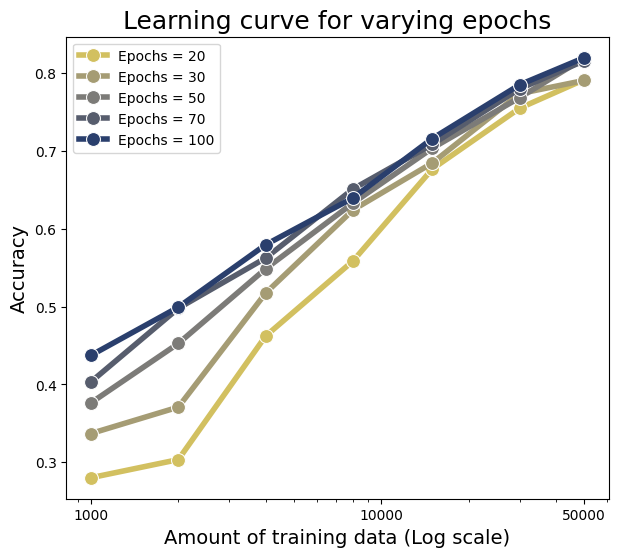

In [11]:
# Prepare the data for seaborn
data_list = []
for epochs, data in lc_orig_dict.items():
    for amount, accuracy in data.items():
        data_list.append({'Epochs': epochs, 'Amount': int(amount), 'Accuracy': accuracy})

df = pd.DataFrame(data_list)

# Create the plot
plt.figure(figsize=my_fig_size)
sns.lineplot(data=df, x='Amount', y='Accuracy', hue='Epochs', marker='o', markersize = ms, linewidth = lw, palette='cividis_r')

# Set log scale for x-axis
plt.xscale('log')

plt.xlabel("Amount of training data (Log scale)", fontsize=label_size)
plt.ylabel("Accuracy", fontsize=label_size)
plt.title("Learning curve for varying epochs", fontsize=title_size)
xticks = [1000, 10000, 50000]
plt.xticks(xticks, labels=[str(x) for x in xticks])
plt.legend(fontsize=legend_size)
plt.show()

## Conventional transformation image samples

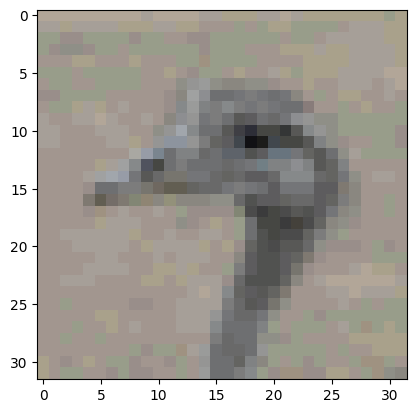

In [14]:
test_img = cv2.imread('data/bird_example.png')
test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
plt.imshow(test_img)
plt.show()

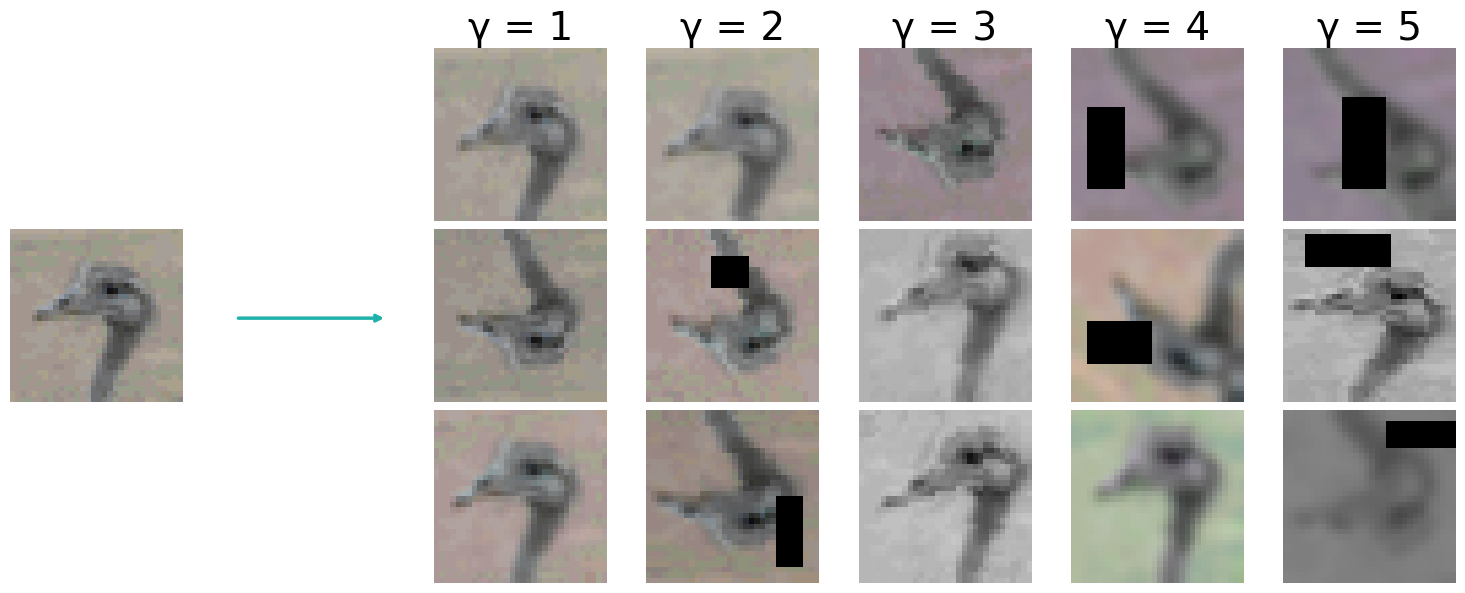

In [38]:
### Standard
nrow = 3
ncol = 7
fig, axes = plt.subplots(nrow, ncol, figsize=(15, 6))
plt.subplots_adjust(hspace=-0.61, wspace=-0.4)
for i in range(nrow):
    for j in range(ncol):
        ax = axes[i, j]
        if j == 0:
            ax.imshow(np.ones((32, 32, 3)))  # White image
            if i == 1:
                ax.imshow(test_img)
            ax.axis('off')
        elif j == 1:
            ax.imshow(np.ones((32, 32, 3)))  # White image
            if i == 1:
                ax.annotate('', xy=(2, 16), xytext=(30, 16), arrowprops=dict(arrowstyle='<-', lw=2.5, color='lightseagreen'))
            ax.axis('off')
        elif j >= 2:
            gamma = j - 1
            img = utils.img_transformation(test_img.T, prob = 1, gamma = gamma, seed = (53 + (i * j))).T
            ax.imshow(img)
            if i == 0:
                ax.set_title(f"γ = {gamma}", fontsize=28) 
            ax.axis('off')
fig.tight_layout()
plt.show()

## Conventional transformation optimisation
### Accuracy vs intensity gamma

In [8]:
acc_conv_gamma_json_name = "scores/acc_vs_conv_gamma.json"

if recalculate_results:
    gamma_list = [0, 0.5, 1, 1.5, 2, 2.5, 3, 4, 5]
    alpha_list = [1.01, 1.5, 2.5, 4, 6, 10]

    test_accs_per_alpha_dict = {}
    repeats = 5
    real_accs_per_aug_ratio = {}
    for ind, alpha in enumerate(alpha_list):
        test_acc_repeats = []
        for i in range(repeats):
            start_time = time.time()
            i_test_acc_list = []

            for gamma in gamma_list:    
                cnn_model = utils.Cifar_CNN(num_channels = 3, classes = 10, dropout_conv = dropout_conv, dropout_fc = dropout_fc).to(device)
                _, _, test_score = utils.nn_trainer(cnn_model, subset_train_dataset, test_dataset, opt_type = "adam", CNN_params_dict=CNN_params_dict, 
                                                    loss_type = "nll", lr_sched = None, device_str = device_name, verbose = False, 
                                                    augmentation = True, aug_ratio = alpha, aug_var = gamma)
                i_test_acc_list += [test_score]
            test_acc_repeats += [i_test_acc_list]
            end_time = time.time()
            print(f"Run for alpha number {ind+1} out of {len(alpha_list)} ({alpha}) and repeat {i+1} of {repeats} complete (note each run tests {len(gamma_list)} gamma options). Runtime = {round(end_time - start_time, 1)} seconds")

        test_accs_per_alpha_dict[alpha] = test_acc_repeats
            
    with open(acc_conv_gamma_json_name, 'w') as json_file:
        json.dump(test_accs_per_alpha_dict, json_file)
else:
    with open(acc_conv_gamma_json_name, 'r') as json_file:
            test_accs_per_alpha_dict = json.load(json_file)

Run for alpha number 1 out of 6 (1.01) and repeat 1 of 5 complete (note each run tests 9 gamma options). Runtime = 559.0 seconds
Run for alpha number 1 out of 6 (1.01) and repeat 2 of 5 complete (note each run tests 9 gamma options). Runtime = 558.7 seconds
Run for alpha number 1 out of 6 (1.01) and repeat 3 of 5 complete (note each run tests 9 gamma options). Runtime = 558.8 seconds
Run for alpha number 1 out of 6 (1.01) and repeat 4 of 5 complete (note each run tests 9 gamma options). Runtime = 558.9 seconds
Run for alpha number 1 out of 6 (1.01) and repeat 5 of 5 complete (note each run tests 9 gamma options). Runtime = 558.8 seconds
Run for alpha number 2 out of 6 (1.5) and repeat 1 of 5 complete (note each run tests 9 gamma options). Runtime = 815.1 seconds
Run for alpha number 2 out of 6 (1.5) and repeat 2 of 5 complete (note each run tests 9 gamma options). Runtime = 815.6 seconds
Run for alpha number 2 out of 6 (1.5) and repeat 3 of 5 complete (note each run tests 9 gamma optio

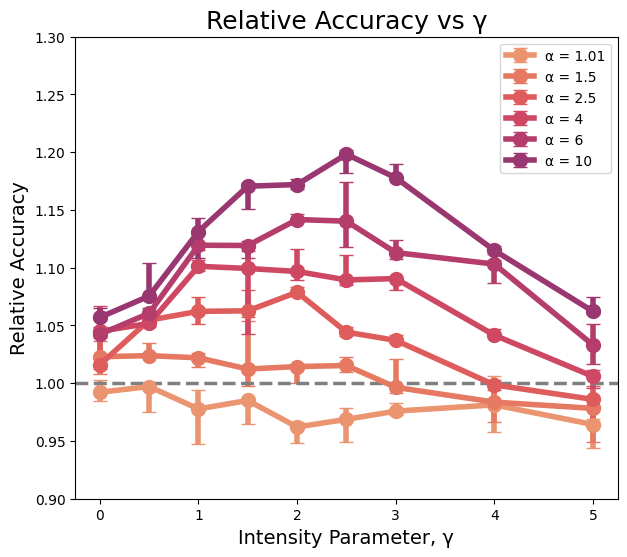

In [12]:
# x_axis = [-1] + var_list
alpha_list = list(test_accs_per_alpha_dict.keys())
gamma_list = [0, 0.5, 1, 1.5, 2, 2.5, 3, 4, 5]

# Prepare the data for seaborn
data_list = []
for alpha in alpha_list:
    this_accs = np.array(test_accs_per_alpha_dict[alpha])
    lq, med, uq = np.percentile(this_accs / avg_baseline_accuracy, [25, 50, 75], axis=0)
    lqd, uqd = med - lq, uq - med

    data_list.append({
        'Augmentation Ratio': alpha,
        'x': gamma_list,
        'Median Accuracy': med,
        'Lower Deviation': lqd,
        'Upper Deviation': uqd
    })

# Convert to DataFrame for easier plotting
df = pd.DataFrame(data_list)

# Create the plot
plt.figure(figsize=my_fig_size)
palette = sns.color_palette('flare', len(alpha_list)+2)

# Plot each augmentation ratio
for i, alpha in enumerate(alpha_list):
    plt.errorbar(df.loc[i, 'x'], df.loc[i, 'Median Accuracy'], 
                 yerr=[df.loc[i, 'Lower Deviation'], df.loc[i, 'Upper Deviation']], 
                 fmt='o-', label=f"α = {alpha}", capsize=5, color=palette[i], 
                 markersize = ms, linewidth = lw)

# Aesthetics
plt.title("Relative Accuracy vs γ", fontsize=title_size)
plt.ylim(0.9, 1.3)
plt.legend(fontsize=legend_size)
plt.xlabel("Intensity Parameter, γ", fontsize=label_size)
plt.ylabel("Relative Accuracy", fontsize=label_size)
plt.axhline(y=1, color='gray', linestyle='--', lw = 2.5)
plt.show()


### Accuracy vs ratio alpha

In [ ]:
aug_var = 3
aug_ratios = [1.5, 2.5, 5, 7, 10, 13, 16, 20, 25, 30, 35, 40, 50]
real_accs_rep = {}
N = 5
for j in range(N):
    t0 = time.time()
    real_accs = []
    for i, aug_ratio in enumerate(aug_ratios):
        print(f"Calculating scores for rep {j+1} of {N}, and aug ratio {i+1} of {len(aug_ratios)}")
        ti = time.time()
        print(f"Calculating for aug_ratio {i+1} out of {len(aug_ratios)} ({aug_ratio}), repeat {j+1} of {N}. Time so far = {round((ti-t0)/60, 1)} minutes.")
        cnn_v2_mod = classification_fns.Cifar_CNN_v2(num_channels = 3, classes = 10, dropout_conv = dropout_conv, dropout_fc = dropout_fc).to(device)
        _, _, real_acc, _ = classification_fns.nn_trainer(cnn_v2_mod, real_sample, test_dataset, device_str = device_name, verbose = False, score_type="acc", 
                                    CNN_params_dict=CNN_params_v2, augmentation = True, aug_ratio = aug_ratio, aug_var = aug_var)
        real_accs += [real_acc]
    real_accs_rep[j] = real_accs


# Save the output dictionary to json file
with open('acc_scores_aug_ratio.json', 'w') as json_file:
    json.dump(real_accs_rep, json_file)

In [ ]:
aug_ratios = [1.5, 2.5, 5, 7, 10, 13, 16, 20, 25, 30, 35, 40, 50]
acc_aug_arr = np.array(list(acc_aug_dict.values()))
lq, med, uq = np.percentile(acc_aug_arr / baseline_accuracy, [25, 50, 75], axis=0)
lqd, uqd = med - lq, uq - med

plt.figure(figsize=(7, 6))

plt.errorbar(aug_ratios, med, yerr=[lqd, uqd], fmt='o-', capsize=5, 
             markeredgecolor='white', markeredgewidth=0.5, markersize=10, linewidth=3)

plt.ylabel("Relative Accuracy", fontsize=12)
plt.xlabel("Augmentation Ratio, $α_c$", fontsize=12)
plt.title("Relative Accuracy vs $α_c$", fontsize=16)
# plt.annotate(f"Error bars showing median & IQR across {len(acc_aug_dict)} tests", 
#              xy=(0.5, 0.97), xycoords='axes fraction', 
#              fontsize=10, ha='center', va='center')
# plt.grid(True)  # Add grid for better readability
plt.show()

### Learning curve on full data with augmentation

## ImageGPT output samples

## GAN output samples

## Accuracy vs FID
### Conventional SD

### ImageGPT

### ??GANs??

## Accuracy vs alpha
### Conventional vs ImageGPT

### Conventional vs GAN

### ??All together with real-only??